In this notebook, we will implement MAML for the sine regressors from [Finn et al (2017)]( https://arxiv.org/abs/1703.03400).

In [543]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict
from src.tasks import Sine_Task, Sine_Task_Distribution

import matplotlib.pyplot as plt

## Model

To implement MAML in Pytorch, we will need a model that can be easily parametrised with a set of weights that's distinct from the model's own parameters. Having these weights distinct from the model.parameters() allows us to easily make differentiable gradient updates within the inner loop.

In [548]:
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
        
    def forward(self, x):
        return self.model(x)
    
    def parameterised(self, x, weights):
        # like forward, but uses ``weights`` instead of ``model.parameters()``
        # it'd be nice if this could be generated automatically for any nn.Module...
        x = nn.functional.linear(x, weights[0], weights[1])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[2], weights[3])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, weights[4], weights[5])
        return x
                        

## MAML

This code implements MAML for Supervised few-shot learning.

It is probably not performance-optimal, but was designed to reproduce the behaviour in the paper while being maximally simple.

In [549]:
class MAML():
    def __init__(self, model, tasks, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=1000):
        
        # important objects
        self.tasks = tasks
        self.model = model
        self.weights = list(model.parameters())
        self.criterion = nn.MSELoss()
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 10
        self.print_every = 10
        self.meta_losses = []
    
    def inner_loop(self, task):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        # perform training on data sampled from task
        X, y = task.sample_data(self.K)
        for step in range(self.inner_steps):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, grad)]
        
        # sample new data for meta-update and compute loss
        X, y = task.sample_data(self.data_batch_size)
        loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
        
        return loss
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        
        for iteration in range(1, num_iterations+1):
            
            # compute meta loss
            meta_loss = 0
            for i in range(self.tasks_per_meta_batch):
                task = self.tasks.sample_task()
                meta_loss += self.inner_loop(task)
            
            # compute meta gradient of loss with respect to weights
            meta_grads = torch.autograd.grad(meta_loss, self.weights)
            
            # assign meta gradient to weights and take optimisation step
            for w, g in zip(self.weights, meta_grads):
                w.grad = g
            self.meta_optimiser.step()
            
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch
            
            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.print_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [550]:
tasks = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)
maml = MAML(MAMLModel(), tasks, inner_lr=0.01, meta_lr=0.001)

In [551]:
maml.main_loop(num_iterations=10000)

10/10000. loss: 0.3977524353027344
20/10000. loss: 0.38459241638183594
30/10000. loss: 0.37845165710449225
40/10000. loss: 0.3687990234375
50/10000. loss: 0.3575201446533203
60/10000. loss: 0.35812701110839845
70/10000. loss: 0.35532796936035155
80/10000. loss: 0.35129318237304685
90/10000. loss: 0.3450951019287109
100/10000. loss: 0.33881174926757807
110/10000. loss: 0.3393559997558594
120/10000. loss: 0.3338342559814453
130/10000. loss: 0.33662850646972664
140/10000. loss: 0.3286142395019531
150/10000. loss: 0.3290799896240234
160/10000. loss: 0.32251277465820316
170/10000. loss: 0.3193043151855469
180/10000. loss: 0.31893640441894533
190/10000. loss: 0.31357156066894537
200/10000. loss: 0.3149789825439453
210/10000. loss: 0.31011339721679687
220/10000. loss: 0.30356799316406247
230/10000. loss: 0.30543080444335946
240/10000. loss: 0.2991122863769531
250/10000. loss: 0.30187992553710935
260/10000. loss: 0.30545235595703124
270/10000. loss: 0.2985887603759766
280/10000. loss: 0.293430

2230/10000. loss: 0.18748238677978515
2240/10000. loss: 0.18656500091552736
2250/10000. loss: 0.18276166992187498
2260/10000. loss: 0.18417279968261718
2270/10000. loss: 0.18391174011230468
2280/10000. loss: 0.18238971557617187
2290/10000. loss: 0.1815137252807617
2300/10000. loss: 0.17967410888671875
2310/10000. loss: 0.1775627212524414
2320/10000. loss: 0.17612249908447264
2330/10000. loss: 0.178887158203125
2340/10000. loss: 0.17749299926757808
2350/10000. loss: 0.17290526580810545
2360/10000. loss: 0.1722908920288086
2370/10000. loss: 0.16978251037597653
2380/10000. loss: 0.16998238677978517
2390/10000. loss: 0.1673895965576172
2400/10000. loss: 0.1688687286376953
2410/10000. loss: 0.16375847473144528
2420/10000. loss: 0.16234498443603515
2430/10000. loss: 0.16156227569580078
2440/10000. loss: 0.15975627746582033
2450/10000. loss: 0.15665789794921875
2460/10000. loss: 0.15456522674560544
2470/10000. loss: 0.15490545349121093
2480/10000. loss: 0.15459842681884767
2490/10000. loss: 0

4400/10000. loss: 0.07855049438476563
4410/10000. loss: 0.07850193862915039
4420/10000. loss: 0.07860983276367188
4430/10000. loss: 0.07860802688598632
4440/10000. loss: 0.07842397994995118
4450/10000. loss: 0.07794744110107422
4460/10000. loss: 0.0792259033203125
4470/10000. loss: 0.07845983963012695
4480/10000. loss: 0.07704855728149414
4490/10000. loss: 0.07650242309570313
4500/10000. loss: 0.07706658401489257
4510/10000. loss: 0.07689259643554687
4520/10000. loss: 0.07823561935424804
4530/10000. loss: 0.07898529434204102
4540/10000. loss: 0.07651813201904298
4550/10000. loss: 0.0780227294921875
4560/10000. loss: 0.0765957649230957
4570/10000. loss: 0.07640131072998047
4580/10000. loss: 0.07891975860595703
4590/10000. loss: 0.07825116958618164
4600/10000. loss: 0.07709678955078125
4610/10000. loss: 0.07626540908813477
4620/10000. loss: 0.07606741867065428
4630/10000. loss: 0.07818681793212891
4640/10000. loss: 0.07669056243896484
4650/10000. loss: 0.07773278198242188
4660/10000. los

6570/10000. loss: 0.06935133590698242
6580/10000. loss: 0.06873962478637695
6590/10000. loss: 0.06784432601928711
6600/10000. loss: 0.0695972541809082
6610/10000. loss: 0.06900045471191406
6620/10000. loss: 0.06894659881591797
6630/10000. loss: 0.0685433822631836
6640/10000. loss: 0.06956780319213866
6650/10000. loss: 0.06793099136352537
6660/10000. loss: 0.06790254287719727
6670/10000. loss: 0.0691531639099121
6680/10000. loss: 0.0686281394958496
6690/10000. loss: 0.06978788375854492
6700/10000. loss: 0.06688604965209961
6710/10000. loss: 0.06874006042480468
6720/10000. loss: 0.06870882110595702
6730/10000. loss: 0.06754673957824707
6740/10000. loss: 0.06607206420898437
6750/10000. loss: 0.06643770942687989
6760/10000. loss: 0.06895445251464845
6770/10000. loss: 0.06885084609985351
6780/10000. loss: 0.06799128112792968
6790/10000. loss: 0.06778967475891115
6800/10000. loss: 0.06813293838500976
6810/10000. loss: 0.06822908020019532
6820/10000. loss: 0.0671919422149658
6830/10000. loss:

8730/10000. loss: 0.05650828018188477
8740/10000. loss: 0.05519340362548828
8750/10000. loss: 0.05656759757995605
8760/10000. loss: 0.05632937049865723
8770/10000. loss: 0.054282555007934566
8780/10000. loss: 0.05443314094543457
8790/10000. loss: 0.05497195892333985
8800/10000. loss: 0.05520843582153321
8810/10000. loss: 0.055472008895874024
8820/10000. loss: 0.05485096092224121
8830/10000. loss: 0.056050337982177734
8840/10000. loss: 0.0553877124786377
8850/10000. loss: 0.055005274963378904
8860/10000. loss: 0.05387327423095702
8870/10000. loss: 0.054554179000854484
8880/10000. loss: 0.05448529434204101
8890/10000. loss: 0.05281449546813964
8900/10000. loss: 0.05457611160278321
8910/10000. loss: 0.05405465812683106
8920/10000. loss: 0.05445750579833984
8930/10000. loss: 0.05341104202270508
8940/10000. loss: 0.05466992340087891
8950/10000. loss: 0.0550402027130127
8960/10000. loss: 0.05686298904418946
8970/10000. loss: 0.054684445190429684
8980/10000. loss: 0.05297503089904785
8990/100

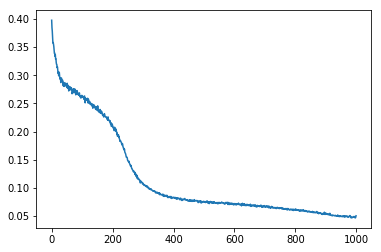

In [552]:
plt.plot(maml.meta_losses)

## Testing and Plotting

Now that the model is trained, let's look at how it performs, and compare it to some naive benchmarks.

In [566]:
def test_on_new_task(initial_model, K, num_steps_measured, x_axis):
    """
    trains the model on a random sine task.
    
    returns the results of the model evaluated on x after the indicated numbers of steps.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    model = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
    model.load_state_dict(initial_model.state_dict())
    criterion = nn.MSELoss()
    optimiser = torch.optim.Adam(model.parameters(), 0.01)

    # train model on a random task
    num_steps = max(num_steps_measured)
    task = tasks.sample_task()
    X, y = task.sample_data(K)
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in num_steps_measured:
            outputs[step] = model(torch.tensor(x, dtype=torch.float).view(-1, 1)).detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    return task, X, y, outputs, losses

In [567]:
def plot_sampled_performance(model):

    x = np.linspace(-5, 5, 100)
    sampled_steps = [1,10]
    task, X, y, outputs, losses = test_on_new_task(model, 10, sampled_steps, x)

    plt.figure(figsize=(15,5))
    
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(x, task.true_function(x), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(X, y, label='data')
    plt.plot(x, outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    
    for step in sampled_steps:
        plt.plot(x, outputs[step], 
                 '-.' if step == 1 else '-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))
        
    plt.legend(loc='lower right')
    plt.title("Model fit")

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

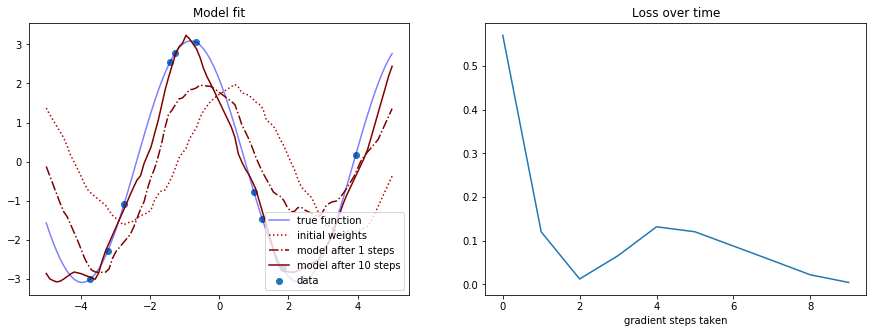

In [583]:
plot_sampled_performance(maml.model.model)

In [585]:
def average_losses(model, n_samples, K=10, n_iterations=10):
    """
    returns the average learning trajectory of the model trained for ``n_iterations`` over ``n_samples`` tasks
    """

    x = np.linspace(-5, 5, 2) # dummy input for test_on_new_task
    sampled_steps = [n_iterations]
    avg_losses = [0] * 10
    for i in range(n_samples):
        _, _, _, _, losses = test_on_new_task(model, K, sampled_steps, x)
        avg_losses = [l + l_new for l, l_new in zip(avg_losses, losses)]
    avg_losses = [l / n_samples for l in avg_losses]
    
    return avg_losses

In [586]:
def mixed_pretrained(iterations=500):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # fit the model
    for i in range(iterations):
        
        model.zero_grad()
        x, y = tasks.sample_task().sample_data(10)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimiser.step()
        
    return model

In [587]:
def random_pretrained(iterations=500):
    """
    returns a model pretrained for ``iterations`` on a random task.
    """
    
    # set up model and task
    model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.ReLU()),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.ReLU()),
            ('l3', nn.Linear(40,1))
        ]))
    task = tasks.sample_task()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # fit the model

    for i in range(iterations):
        model.zero_grad()
        x, y = task.sample_data(10)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimiser.step()
        return model

In [574]:
pretrained = mixed_pretrained(10000)

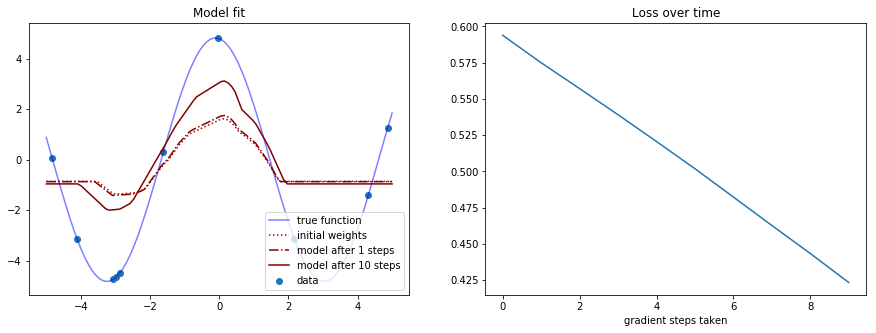

In [578]:
plot_sampled_performance(pretrained)

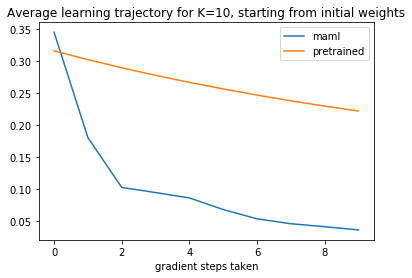

In [584]:
plt.plot(average_losses(maml.model.model, 1000, K=10), label='maml')
plt.plot(average_losses(pretrained, 1000, K=10),       label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=10, starting from initial weights")
plt.xlabel("gradient steps taken")
plt.show()

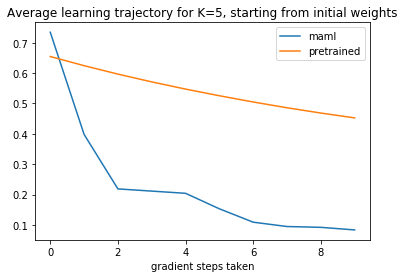

In [589]:
plt.plot(average_losses(maml.model.model, 1000, K=5), label='maml')
plt.plot(average_losses(pretrained, 1000, K=5),       label='pretrained')
plt.legend()
plt.title("Average learning trajectory for K=5, starting from initial weights")
plt.xlabel("gradient steps taken")
plt.show()

While not as dramatic as the comparison in the paper, the MAML weights clearly learn much faster than the baseline pretrained model. The MAML learning curve is also peculiar in shape. Perhaps training the inner models for more steps, and modifying the inner loop to record the sum of the loss at each step to be output as the meta-loss, could make the curve nicer. Doing that would overcomplicate the code here, however.